In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # specify which GPU to use
import torch
import cwm.utils as utils
from torchvision.io import read_image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from cwm.model.model_factory import model_factory

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load Pre-trained CWM Model

In [2]:
# Load CWM 3-frame model (automatically download pre-trained checkpoint)
model = model_factory.load_model('vitb_8x8patch_3frames').cuda() 

Model loaded successfully


## Prepare model inputs

In [3]:
# Load input image from an image path
img_path = '/ccn2/u/honglinc/bbnet_notebooks/jordon.jpeg' 

# normalized to the range [0, 1]
img = read_image(img_path)[:, :1480].cuda() / 255. 

# resize image to input resolution [224, 224]
img = torch.nn.functional.interpolate(img[None], size=224, mode='bicubic') 

# reshape image to [B, C, T, H, W], C = 3, T = 3 (3-frame model), H = W = 224
x = img[:, :, None].expand(-1, -1, 3, -1, -1).to(torch.float16) 

# Imagenet-normalize the inputs (standardization)
x = utils.imagenet_normalize(x)

# Prepare masks for the 3-frame model: 28x28=784 patches per image, the first two are unmasked, last one is masked
bool_masked_pos = torch.ones(1, 784*3).to(x.device).bool()
bool_masked_pos[:, 0:784*2] = False

# patch size
patch_size = model.encoder.patch_size[-1]

## Generate counterfactual predictions

In [5]:
move_patches=[[8, 11], [16, 12], [22, 4]] # Specify which patches to move
static_patches=[[10, 22], [4, 4]] # Specify which patches to hold still
delta = [-3, -1] # Specify the direction of motion

# Model inference
with torch.cuda.amp.autocast(enabled=True):
    output = model.get_counterfactual(x, bool_masked_pos, move_patches, static_patches, delta) # model reconstruction output
    recon = utils.unpatchify_cwm(output, patch_size=patch_size, mask=bool_masked_pos[:, -784:]) # reshape the output to an image  

torch.Size([1, 784, 192]) torch.Size([1, 784]) torch.Size([1, 784, 192]) 28 28


## Visualization

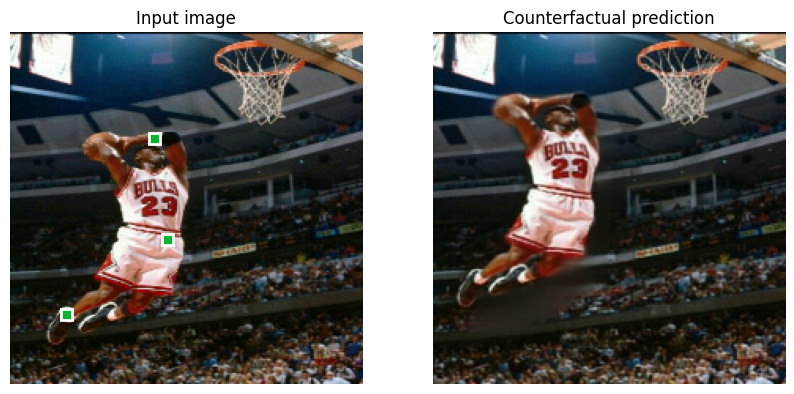

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Visualize the input image and selected patches
axs[0].imshow(img.cpu()[0].permute(1,2,0).clamp(0, 1))
axs[0].set_axis_off()
axs[0].set_title('Input image')

for (px, py) in move_patches:
    circle = patches.Rectangle((py * patch_size, px * patch_size), 7, 7, facecolor='#00b530', edgecolor='white', linewidth=2, label='moving')
    axs[0].add_patch(circle)

# Visualize the counterfactual prediction
axs[1].imshow(recon[0].clamp(0, 1).float().permute(1,2,0).cpu().detach())
axs[1].set_axis_off()
axs[1].set_title('Counterfactual prediction')
plt.show()